### Author: William C Francis (willcf)
##Solution 2
### (i)

In [65]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


####Downloading the dataset

In [66]:
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()
x_val_pre = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()

### Creating x_train and y_train with 1000 images from each class and binarizing the pixels

In [67]:
count = np.zeros(10)
idx = []
for i in range(0, len(ytrain)):
  for j in range(10):
    if(ytrain[i] == j):
      count[j] += 1
      if(count[j]<=1000):
        idx = np.append(idx, i)
        
y_train = ytrain[idx.astype('int')]
x_train_pre = xtrain[idx.astype('int')]

### Resizing the images from 28x28 to 14x14

In [68]:
r,_,_ = x_train_pre.shape
x_train = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_train_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_train[i] = a

r,_,_ = x_val_pre.shape
x_val = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_val_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_val[i] = a

### Binarizing 

In [69]:
x_train = np.where(x_train > 128, 1, 0)
x_val = np.where(x_val > 128, 1, 0)
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)

### Creating dataloaders

In [70]:
batch_size = 32
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)

###(ii)
### Variational Auto Encoder model

In [71]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(196, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 196)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std
    
    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 196))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
model = VAE()
if torch.cuda.is_available():
    model.cuda()

### Defining loss, optimizer and LR scheduler

In [72]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001, verbose=True)

def loss_function(y, x, mu, std): 
    ERR = F.binary_cross_entropy(y, x.view(-1, 196), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, -ERR, -KLD

c:\Users\ebaem\anaconda3\envs\cse446\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### Training and Validating

In [73]:
count=0
err_l, kld_l, n_wu, testl, update = [], [], [], [], []
for epoch in range(1, 20):
    
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        model.train()
        data = data.cuda()
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item()/bsize)
        kld_l.append(kld.item()/bsize)
        count+=1
        n_wu.append(count)

        if (count%100 == 0): # Validating every 100 weight updates
          model.eval()
          a, _ = next(iter(testloader))
          a = a.cuda()
          trecon, tmu, tstd = model(a)
          tloss, terr, tkld = loss_function(trecon, a, tmu, tstd)
          testl.append(terr/100)
          update.append(count)

    scheduler.step(train_loss / len(trainloader.dataset))
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in testloader:
            data = data.cuda()
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += err + kld
    
    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

====> Epoch: 1 Average loss: -53.0190
====> Test set loss: -42.7307
====> Epoch: 2 Average loss: -40.8958
====> Test set loss: -39.0912
====> Epoch: 3 Average loss: -38.2170
====> Test set loss: -37.1194
====> Epoch: 4 Average loss: -36.6509
====> Test set loss: -36.1006
====> Epoch: 5 Average loss: -35.8669
====> Test set loss: -35.5076
====> Epoch: 6 Average loss: -35.2180
====> Test set loss: -35.0015
====> Epoch: 7 Average loss: -34.7096
====> Test set loss: -34.6588
====> Epoch: 8 Average loss: -34.3108
====> Test set loss: -34.3927
====> Epoch: 9 Average loss: -34.0053
====> Test set loss: -33.8916
====> Epoch: 10 Average loss: -33.7300
====> Test set loss: -33.8081
====> Epoch: 11 Average loss: -33.4820
====> Test set loss: -33.7519
====> Epoch: 12 Average loss: -33.2766
====> Test set loss: -33.7466
====> Epoch: 13 Average loss: -33.1051
====> Test set loss: -33.2753
====> Epoch: 14 Average loss: -32.9108
====> Test set loss: -33.2384
====> Epoch: 15 Average loss: -32.7591
====

### (iii) Plotting the first and second term of ELBO as a function of weight updates

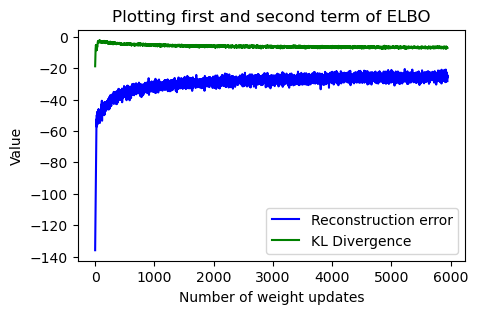

In [74]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, err_l, 'b', label='Reconstruction error')
plt.plot(n_wu, kld_l, 'g', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()
    

### (iv) 
### Visualizing input and output from the VAE from training set

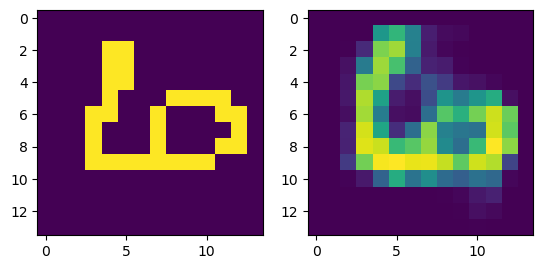

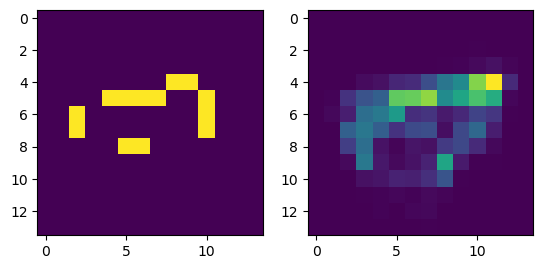

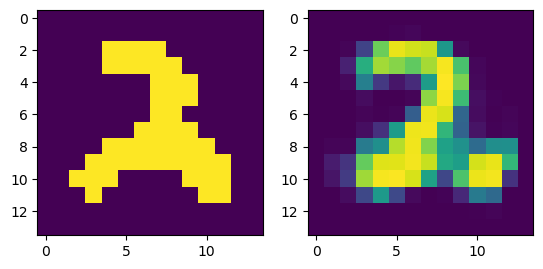

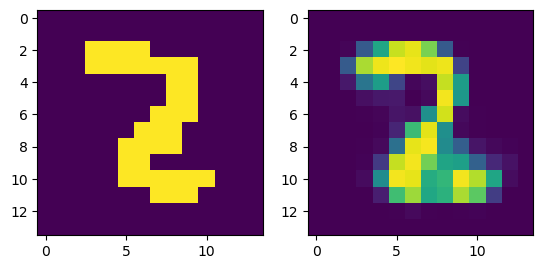

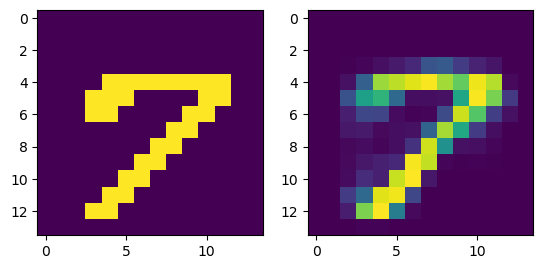

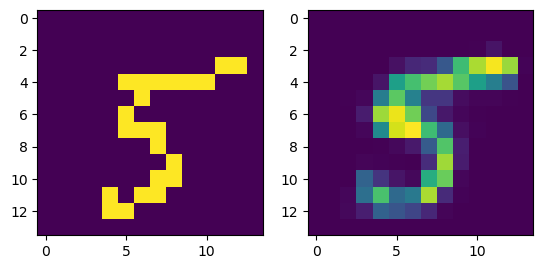

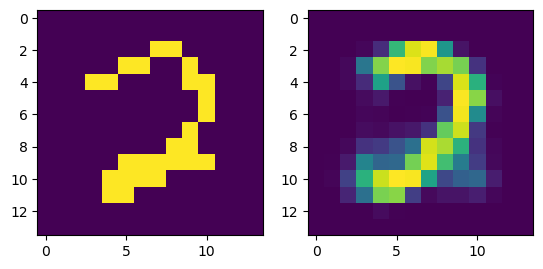

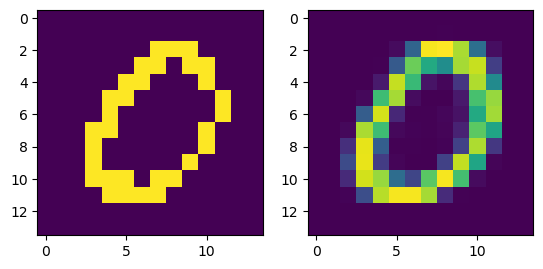

In [75]:
model.eval()
for i in range(8):
  a,t = next(iter(trainloader))
  a = a.cuda()
  recon, mu, std = model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(a[0].detach().cpu().numpy())
  axarr[1].imshow(b.detach().cpu().numpy())

### Visualizing input and output of the VAE from validation set

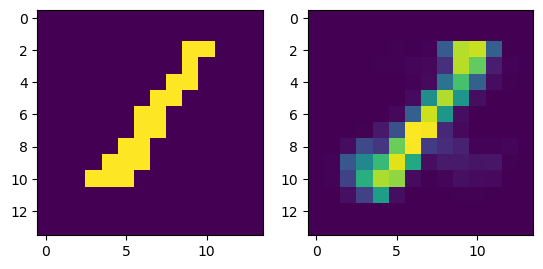

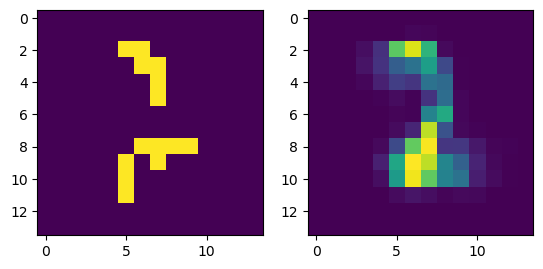

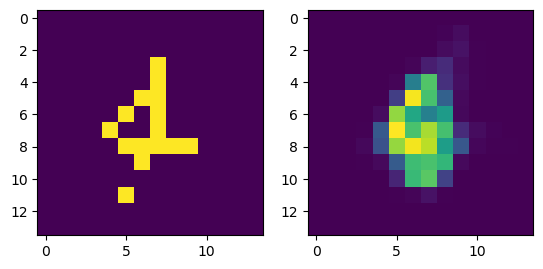

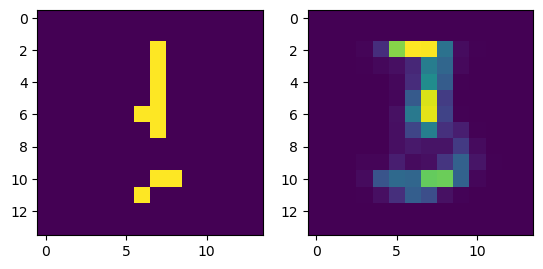

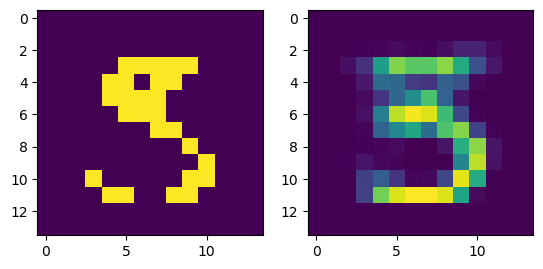

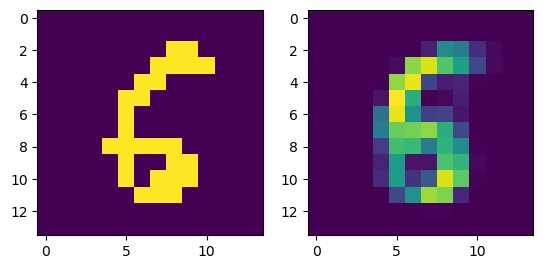

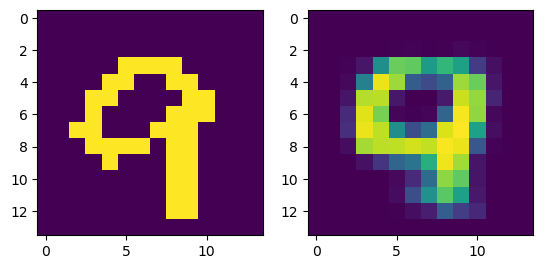

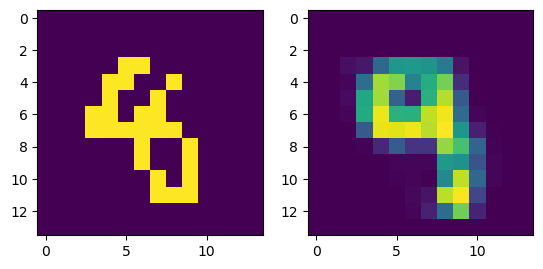

In [76]:
model.eval()
for i in range(8):
  a,t = next(iter(testloader))
  a = a.cuda()
  recon, mu, std = model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(a[0].detach().cpu().numpy())
  axarr[1].imshow(b.detach().cpu().numpy())

### (v)
### Synthesizing MNIST images from a Standard Gaussian Distribution

tensor([-1.1040,  0.2930, -0.5617, -0.4808,  0.9306,  0.6722, -0.8269,  1.3981],
       device='cuda:0')
tensor([ 0.2141,  1.2591, -0.7424, -1.9832, -0.5349, -2.2639, -1.3340, -1.5027],
       device='cuda:0')
tensor([ 0.4224, -0.2571,  0.9958, -1.4840, -0.0417,  0.3430,  1.0121, -1.4043],
       device='cuda:0')
tensor([-0.2862,  2.1115, -0.2688, -0.6784, -0.2339,  0.7740, -0.1308, -1.2003],
       device='cuda:0')
tensor([ 0.7921, -0.6822,  0.9361,  1.9709, -1.0201,  0.6540,  0.6969, -1.4379],
       device='cuda:0')
tensor([ 1.9656, -0.7328,  1.1615,  0.2073,  0.5712, -0.9240,  0.6179, -1.4340],
       device='cuda:0')
tensor([-0.2593, -0.5117,  0.1806,  0.3575,  1.3337, -0.0170,  0.8067, -0.7851],
       device='cuda:0')
tensor([-0.5497, -0.1704, -0.4346, -0.2455,  0.8783, -1.7277, -0.0633,  0.0356],
       device='cuda:0')


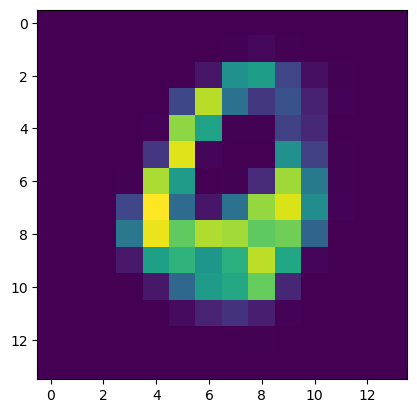

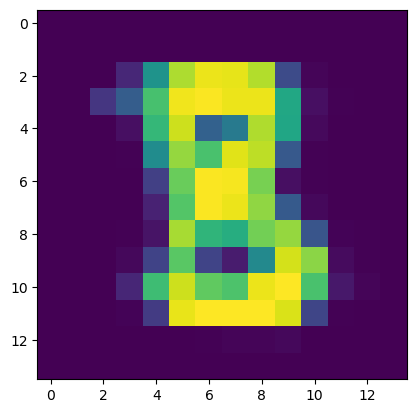

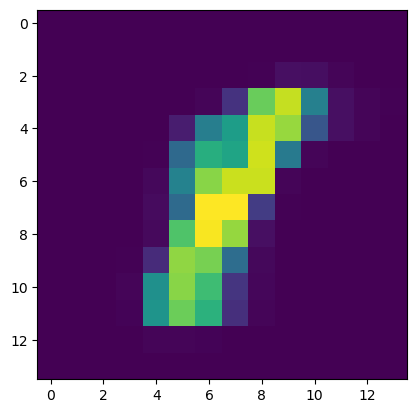

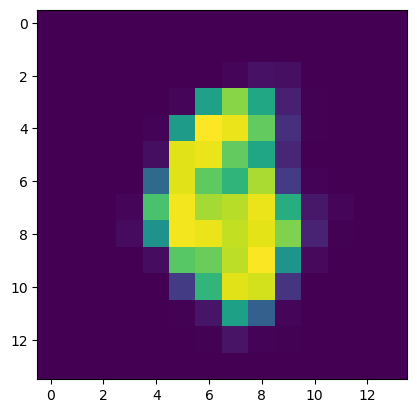

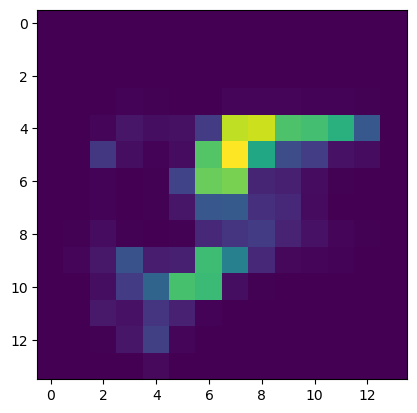

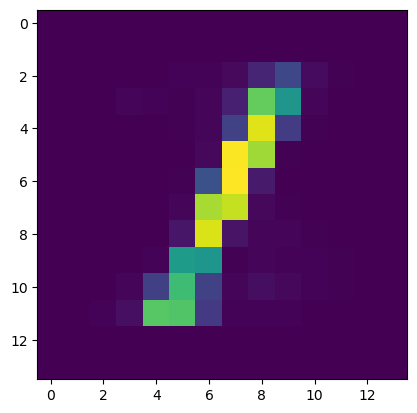

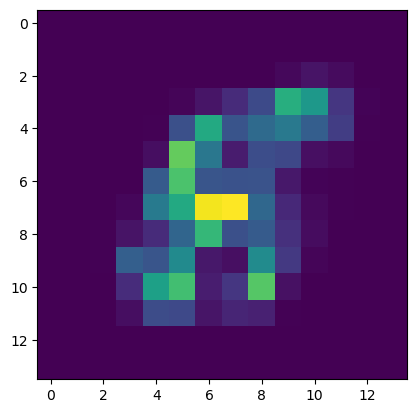

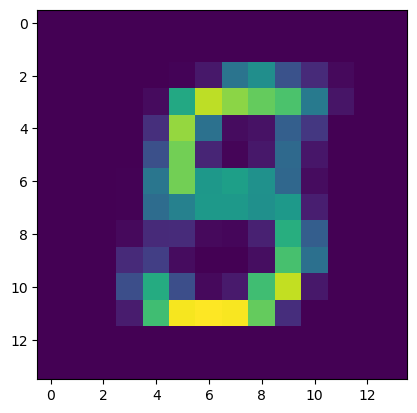

In [77]:

for i in range(8):
  
  x = np.random.normal(0,1, 8)
  x= x.astype(np.float32)
  x=torch.from_numpy(x)
  x= x.cuda()
  recon = model.decoder(x)
  b = recon.reshape((14,14))
  print(x)
  f, axarr = plt.subplots(1) 
  axarr.imshow(b.detach().cpu().numpy())

### (vi)
### Comparing the reconstruction log likelihood term in ELBO on Training vs Validation set

In [78]:
print(update)
print(len(update))

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900]
59


In [79]:
print(testl)
print(len(testl))

[tensor(-47.2592, device='cuda:0', grad_fn=<DivBackward0>), tensor(-42.0665, device='cuda:0', grad_fn=<DivBackward0>), tensor(-39.3695, device='cuda:0', grad_fn=<DivBackward0>), tensor(-35.5010, device='cuda:0', grad_fn=<DivBackward0>), tensor(-36.3775, device='cuda:0', grad_fn=<DivBackward0>), tensor(-36.1988, device='cuda:0', grad_fn=<DivBackward0>), tensor(-33.1828, device='cuda:0', grad_fn=<DivBackward0>), tensor(-31.7085, device='cuda:0', grad_fn=<DivBackward0>), tensor(-31.7552, device='cuda:0', grad_fn=<DivBackward0>), tensor(-32.8976, device='cuda:0', grad_fn=<DivBackward0>), tensor(-30.8924, device='cuda:0', grad_fn=<DivBackward0>), tensor(-32.2673, device='cuda:0', grad_fn=<DivBackward0>), tensor(-31.6624, device='cuda:0', grad_fn=<DivBackward0>), tensor(-28.8935, device='cuda:0', grad_fn=<DivBackward0>), tensor(-30.6921, device='cuda:0', grad_fn=<DivBackward0>), tensor(-28.9308, device='cuda:0', grad_fn=<DivBackward0>), tensor(-30.0661, device='cuda:0', grad_fn=<DivBackward0

In [80]:
print(testl[1])
test = testl[1].cpu()
print(test)

tensor(-42.0665, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-42.0665, grad_fn=<ToCopyBackward0>)


In [81]:
# convert all element's device type cuda -> cpu
testl_cpu = [val.data.cpu() for val in testl]

print(testl_cpu)
print(len(testl_cpu))

[tensor(-47.2592), tensor(-42.0665), tensor(-39.3695), tensor(-35.5010), tensor(-36.3775), tensor(-36.1988), tensor(-33.1828), tensor(-31.7085), tensor(-31.7552), tensor(-32.8976), tensor(-30.8924), tensor(-32.2673), tensor(-31.6624), tensor(-28.8935), tensor(-30.6921), tensor(-28.9308), tensor(-30.0661), tensor(-29.2877), tensor(-27.8001), tensor(-29.6217), tensor(-29.9015), tensor(-27.9111), tensor(-30.2983), tensor(-29.3793), tensor(-28.2054), tensor(-27.9465), tensor(-28.2651), tensor(-28.7613), tensor(-28.9894), tensor(-27.4239), tensor(-29.1173), tensor(-29.0927), tensor(-27.0049), tensor(-28.0846), tensor(-26.6326), tensor(-27.8343), tensor(-27.2119), tensor(-27.0125), tensor(-26.3575), tensor(-28.6588), tensor(-27.4549), tensor(-27.3612), tensor(-26.9902), tensor(-26.9347), tensor(-29.2412), tensor(-27.2151), tensor(-26.7996), tensor(-27.0880), tensor(-25.8678), tensor(-24.9407), tensor(-26.5921), tensor(-26.4775), tensor(-27.2638), tensor(-26.9573), tensor(-25.2788), tensor(-2

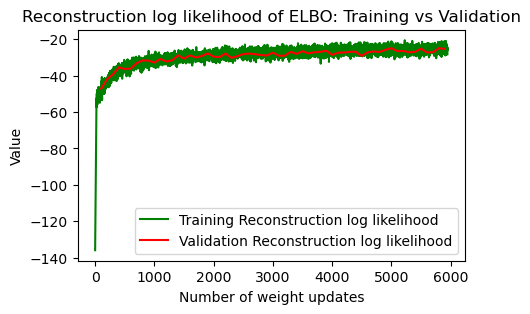

In [82]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(err_l, 'g', label='Training Reconstruction log likelihood')
plt.plot(update, testl_cpu, 'r', label='Validation Reconstruction log likelihood')
plt.title('Reconstruction log likelihood of ELBO: Training vs Validation')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()